In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ang_res = 1
x = np.random.uniform(0,1,5000)*ang_res
y = np.random.uniform(0,1,5000)*ang_res

#means of normal distribution
mu1 = [0.6*ang_res, 0.5*ang_res]
mu2 = [0.3*ang_res, 0.8*ang_res] 
mu3 = [0.9*ang_res, 0.7*ang_res]

#covariance values:
c1 = [[0.0002*ang_res,0],[0,0.0002*ang_res]]
c2 = [[0.0002*ang_res,0],[0,0.0002*ang_res]]
c3 = [[0.0002*ang_res,0],[0,0.0002*ang_res]]

#getting the distribution for peak reagions
d1 = np.random.multivariate_normal(mu1, c1, (100,100))
d2 = np.random.multivariate_normal(mu2, c2, (100,100))
d3 = np.random.multivariate_normal(mu3, c3, (100,100))

d = [d1,d2,d3]

#appending to x and y corrdinates
X = x.copy()
Y = y.copy()
for dist in d:
    dr1 = dist[:,:,0]
    dr2 = dist[:,:,1]
    X = np.concatenate((X,dr1[0]))
    Y = np.concatenate((Y,dr2[1]))

del d,d1,d2,d3

In [3]:
#getting the density map
des_map = np.histogram2d(X,Y,bins=64)

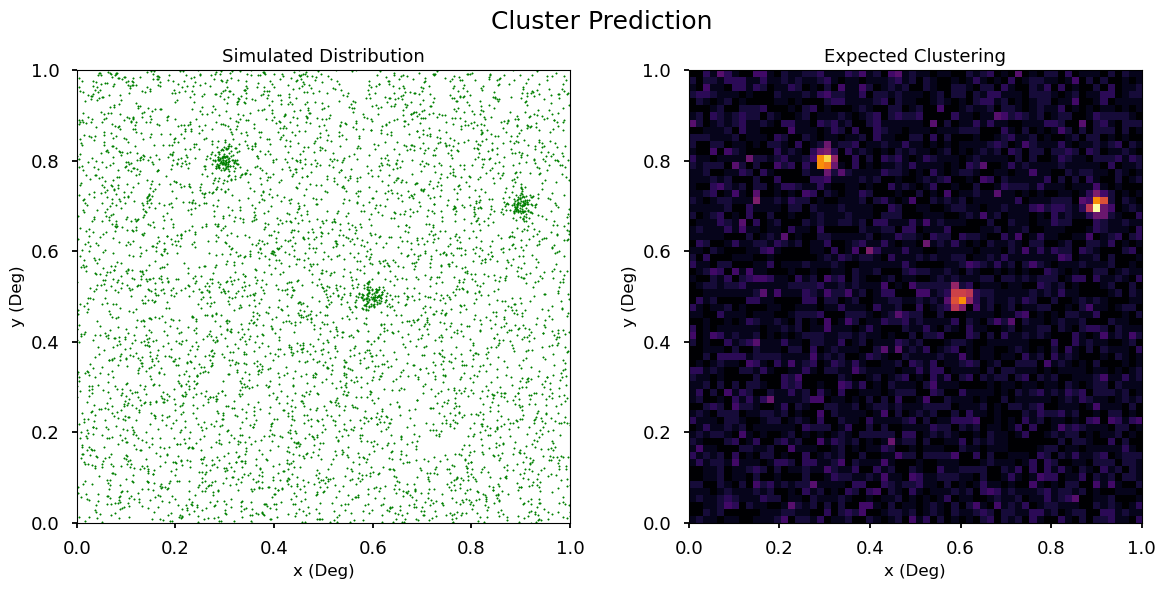

In [9]:
plt.rcParams["font.family"] = 'sans-serif'
plt.style.use('seaborn-talk')

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=100, gridspec_kw={'wspace':0.2})
ax[0].scatter(X,Y,s=1,c='green')
ax[0].set_xlim(0,ang_res)
ax[0].set_ylim(0,ang_res)

ax[1].imshow(des_map[0].T, origin='lower',cmap='inferno', extent=[0,ang_res,0,ang_res])

ax[0].set_title('Simulated Distribution',fontsize=13)
ax[1].set_title('Expected Clustering'   ,fontsize=13)

for i in range(2):
    ax[i].set_xlabel('x (Deg)',fontsize=12);
    ax[i].set_ylabel('y (Deg)',fontsize=12);
    ax[i].grid(False)
fig.suptitle('Cluster Prediction', fontsize=18);

plt.savefig('simulated.jpg', bbox_inches='tight', dpi=200)